In [1]:
import hopsworks
from sklearn.neighbors import KNeighborsClassifier
import hsfs
import numpy as np
import joblib
import os

In [2]:
# Uncomment this cell and fill in details if you are running your own Hopsworks cluster
#!echo "xxxx" > api-key.txt
# key=""
# with open("api-key.txt", "r") as f:
#     key = f.read().rstrip()
# os.environ['HOPSWORKS_PROJECT']="cjsurf"
# os.environ['HOPSWORKS_HOST']="35.187.178.84"
# os.environ['HOPSWORKS_API_KEY']=key

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/135
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
hours=119

standard_scaler = fs.get_transformation_function(name="standard_scaler")

transformation_functions = {
    "height": standard_scaler,
    "period": standard_scaler,
    "direction": standard_scaler,
}
for i in range(1,hours):
    transformation_functions["height" + str(i*2)]=standard_scaler
    transformation_functions["period" + str(i*2)]=standard_scaler
    transformation_functions["direction" + str(i*2)]=standard_scaler    

In [5]:
lahinch_fg = fs.get_feature_group("lahinch", version=2)
swells_fg = fs.get_feature_group("swells_exploded", version=10)
query = lahinch_fg.select(['wave_height']).join(
    swells_fg.select_except(['beach_id'])) 

In [6]:
version=1
try: 
    fv = fs.get_feature_view("lahinch_surf", version=version)
except:
    fv = fs.create_feature_view(name='lahinch_surf', 
                            description="Lahinch surf height prediction features",
                            version=version,
                            labels=["wave_height"],
                            query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/135/fs/81/fv/lahinch_surf/version/1


In [ ]:
#X_train,y_train,X_test,y_test = fv.train_test_split(0.1)

In [7]:
td_version, td_job = fv.create_train_test_split(
    description = 'cjsurf training data',
    data_format = 'csv',
    test_size = 0.1,
    write_options = {'wait_for_job': True}
)

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/135/jobs/named/lahinch_surf_1_1_create_fv_td_03072022210709/executions


In [8]:
X_train, y_train, X_test, y_test = fv.get_train_test_split(td_version)

In [9]:
X_train = X_train[['height', 'period', 'direction']]
X_test = X_test[['height', 'period', 'direction']]
X_train

,height,period,direction
0,0.6,11.1,86
1,1.1,9.6,128
2,1.3,7.8,112
3,2.1,12.5,93
4,0.2,10.3,108
...,...,...,...
314,2.6,10.2,133
315,4.3,11.6,74
316,0.8,8.3,109
317,1.5,8.4,103


In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_encoded=le.fit_transform(y_train['wave_height'])
y_test_encoded=le.fit_transform(y_test['wave_height'])

In [11]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train,y_train_encoded)

KNeighborsClassifier(n_neighbors=3)

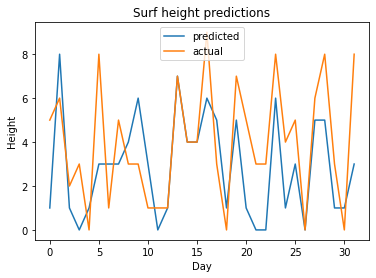

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
%matplotlib inline

y_pred = model.predict(X_test)

precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test_encoded, y_pred, average="weighted", zero_division=1)

rmse = mean_squared_error(y_test_encoded, y_pred)

# We model surf height prediction as a classification problem, as there
# only a small number of heights reported on Lahinch beach, but the RMSE
# is still a useful metric for evaluating if your model is more accurate or not
metrics = {
    "precision" : precision,
    "recall" : recall,
    "fscore" : fscore,
    "rmse" : rmse
}

error_rates = []
num_samples=len(y_pred)
for a in range(1, num_samples):
    error_rates.append(np.mean(y_test_encoded[a] - y_pred))

plt.plot(range(0,num_samples), y_pred, label="predicted")
plt.plot(range(0,num_samples), y_test_encoded, label="actual")
plt.title('Surf height predictions')
plt.xlabel('Day')
plt.ylabel('Height')
plt.legend()
plt.show()

In [14]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

project = hopsworks.login()

mr = project.get_model_registry()
joblib.dump(model, 'knn_model.pkl')

input_example = X_train.sample()
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

knn_model = mr.python.create_model(
    version=3,
    name="cjsurf_model", 
    metrics=metrics,
    model_schema=model_schema,
    input_example=input_example, description="Lahinch Surf height predictions")

knn_model.save("knn_model.pkl")

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/135
Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/135/models/cjsurf_model/3


Model(name: 'cjsurf_model', version: 3)

In [ ]:
model_deployment = knn_model.deploy(name="cjsurf",
                                    model_server="PYTHON",
                                    serving_tool="KSERVE"
                                   )

In [ ]:
model_deployment.start()